In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import sys

from fredapi import Fred

sys.path.append('../economic_data_analysis_with_pandas')
from settings import FRED_API_KEY as fred_key

# Setup

In [2]:

plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 500)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]


# Interact with Fred

In [ ]:

# Create the Fred object
fred = Fred(api_key=fred_key)

# General search for economic data on Fred to get a feeling for the content
fred.search('S&P')

id realtime_start realtime_end  \
series id                                                        
CSUSHPINSA              CSUSHPINSA     2025-03-04   2025-03-04   
CSUSHPISA                CSUSHPISA     2025-03-04   2025-03-04   
SP500                        SP500     2025-03-04   2025-03-04   
SPCS20RSA                SPCS20RSA     2025-03-04   2025-03-04   
SPCS20RNSA              SPCS20RNSA     2025-03-04   2025-03-04   
...                            ...            ...          ...   
EMVIPMAT                  EMVIPMAT     2025-03-04   2025-03-04   
HC01ESTVC1612065  HC01ESTVC1612065     2025-03-04   2025-03-04   
HC01ESTVC1628149  HC01ESTVC1628149     2025-03-04   2025-03-04   
HC01ESTVC1640133  HC01ESTVC1640133     2025-03-04   2025-03-04   
HC01ESTVC1636037  HC01ESTVC1636037     2025-03-04   2025-03-04   

                                                              title  \
series id                                                             
CSUSHPINSA        S&P CoreLogic Case-Shiller U.S. National Home ...   
CSUSHPISA         S&P CoreLogic Case-Shiller U.S. National Home ...   
SP500                                                       S&P 500   
SPCS20RSA         S&P CoreLogic Case-Shiller 20-City Composite H...   
SPCS20RNSA        S&P CoreLogic Case-Shiller 20-City Composite H...   
...                                                             ...   
EMVIPMAT          Equity Market Volatility Tracker: Intellectual...   
HC01ESTVC1612065  High School Graduate or Higher (5-year estimat...   
HC01ESTVC1628149  High School Graduate or Higher (5-year estimat...   
HC01ESTVC1640133  High School Graduate or Higher (5-year estimat...   
HC01ESTVC1636037  High School Graduate or Higher (5-year estimat...   

                 observation_start observation_end     frequency  \
series id                                                          
CSUSHPINSA              1987-01-01      2024-12-01       Monthly   
CSUSHPISA               1987-01-01      2024-12-01       Monthly   
SP500                   2015-03-04      2025-03-03  Daily, Close   
SPCS20RSA               2000-01-01      2024-12-01       Monthly   
SPCS20RNSA              2000-01-01      2024-12-01       Monthly   
...                            ...             ...           ...   
EMVIPMAT                1985-01-01      2025-01-01       Monthly   
HC01ESTVC1612065        2010-01-01      2023-01-01        Annual   
HC01ESTVC1628149        2010-01-01      2023-01-01        Annual   
HC01ESTVC1640133        2010-01-01      2023-01-01        Annual   
HC01ESTVC1636037        2010-01-01      2023-01-01        Annual   

                 frequency_short               units         units_short  \
series id                                                                  
CSUSHPINSA                     M  Index Jan 2000=100  Index Jan 2000=100   
CSUSHPISA                      M  Index Jan 2000=100  Index Jan 2000=100   
SP500                          D               Index               Index   
SPCS20RSA                      M  Index Jan 2000=100  Index Jan 2000=100   
SPCS20RNSA                     M  Index Jan 2000=100  Index Jan 2000=100   
...                          ...                 ...                 ...   
EMVIPMAT                       M               Index               Index   
HC01ESTVC1612065               A             Percent                   %   
HC01ESTVC1628149               A             Percent                   %   
HC01ESTVC1640133               A             Percent                   %   
HC01ESTVC1636037               A             Percent                   %   

                      seasonal_adjustment seasonal_adjustment_short  \
series id                                                             
CSUSHPINSA        Not Seasonally Adjusted                       NSA   
CSUSHPISA             Seasonally Adjusted                        SA   
SP500             Not Seasonally Adjusted                       NSA   
SPCS20RSA           

<Axes: title={'center': 'S&P 500'}>

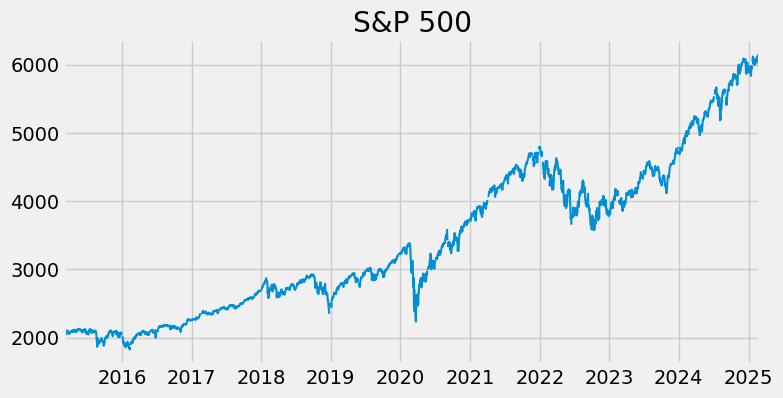

In [4]:

# Pull raw data
sp500 = fred.get_series(series_id='SP500')

# eda
sp500.plot(figsize=(8,4), title='S&P 500', lw=1.5)


# Pull and Join Multiple Time Series

## Unemployment Rate

In [5]:
unemp_df_raw = fred.search('unemployment state rate', filter=('frequency', 'Monthly'), order_by='popularity', limit=2000)
unemp_df = unemp_df_raw.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')
unemp_df = unemp_df.loc[unemp_df['title'].str.contains('Unemployment Rate')]
unemp_df = unemp_df.loc[unemp_df['id'].str.endswith('UR')]
unemp_df = unemp_df.loc[unemp_df['id'].str.len() == 4]
unemp_id_to_state = unemp_df['title'].str.replace('Unemployment Rate in ', '').to_dict()

In [6]:
all_results = []

for myid in unemp_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)

unemp_results = pd.concat(all_results, axis=1).drop(['PRUR'], axis=1)
unemp_results.columns = [unemp_id_to_state[c] for c in unemp_results.columns]
unemp_results.rename(columns={'the District of Columbia':'DC'}, inplace=True)

# null-check
# unemp_results.isna().sum(axis=1).plot()

In [7]:
# Plot States unemployment rate
px.line(unemp_results)

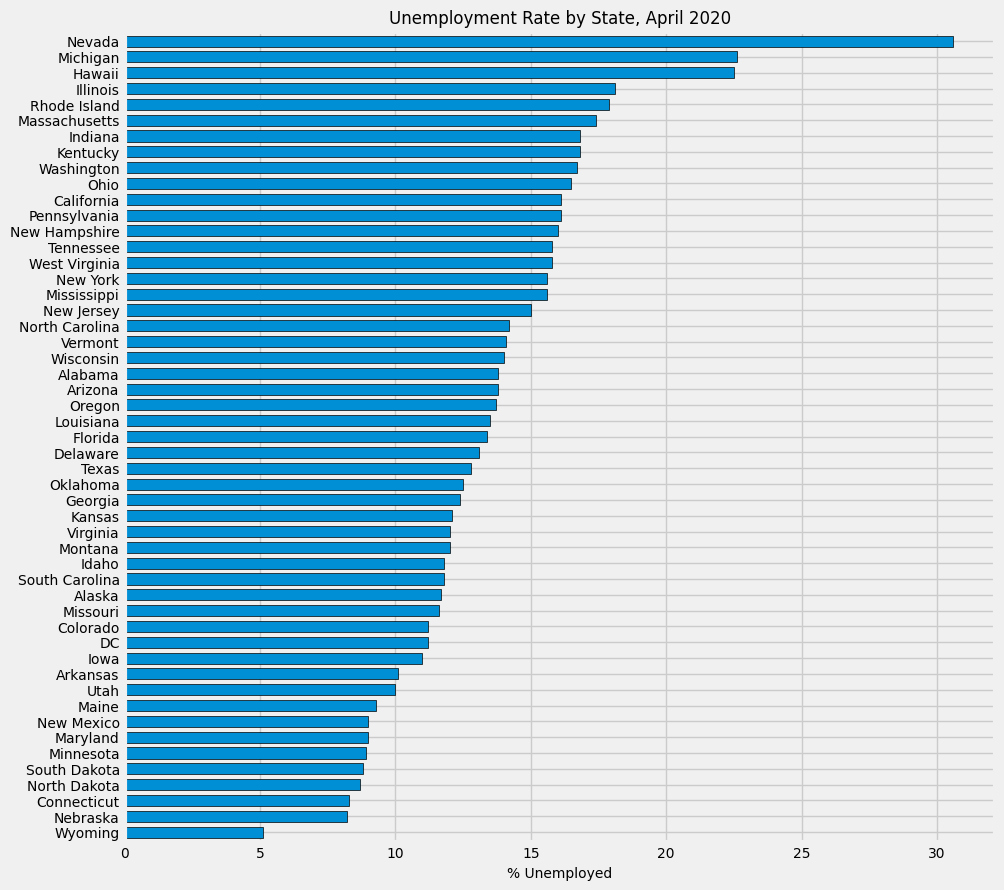

In [8]:
ax = unemp_results.loc[unemp_results.index == '2020-04-01'].T \
        .sort_values('2020-04-01') \
        .plot(kind='barh',
              figsize=(10,10),
              edgecolor = 'black',
              width = 0.7)
ax.legend().remove()
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.title('Unemployment Rate by State, April 2020', fontsize=12)
ax.set_xlabel('% Unemployed', fontsize=10)
plt.show()

## Participation Rate

In [9]:
part_df_raw = fred.search('participation state rate', filter=('frequency', 'Monthly'), order_by='popularity', limit=2000)
part_df = part_df_raw.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')
part_df = part_df.loc[part_df['title'].str.contains('Labor Force Participation Rate for ')]
part_id_to_state = part_df['title'].str.replace('Labor Force Participation Rate for ', '').to_dict()

In [10]:
all_results = []

for myid in part_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)

part_results = pd.concat(all_results, axis=1)
part_results.columns = [part_id_to_state[c] for c in part_results.columns]
part_results.rename(columns={'District Of Columbia':'DC'}, inplace=True)

# null-check
# unemp_results.isna().sum(axis=1).plot()

In [11]:
# Plot States Labor Force Participation Rate
px.line(part_results)

## Plot Unemployment vs. Participation

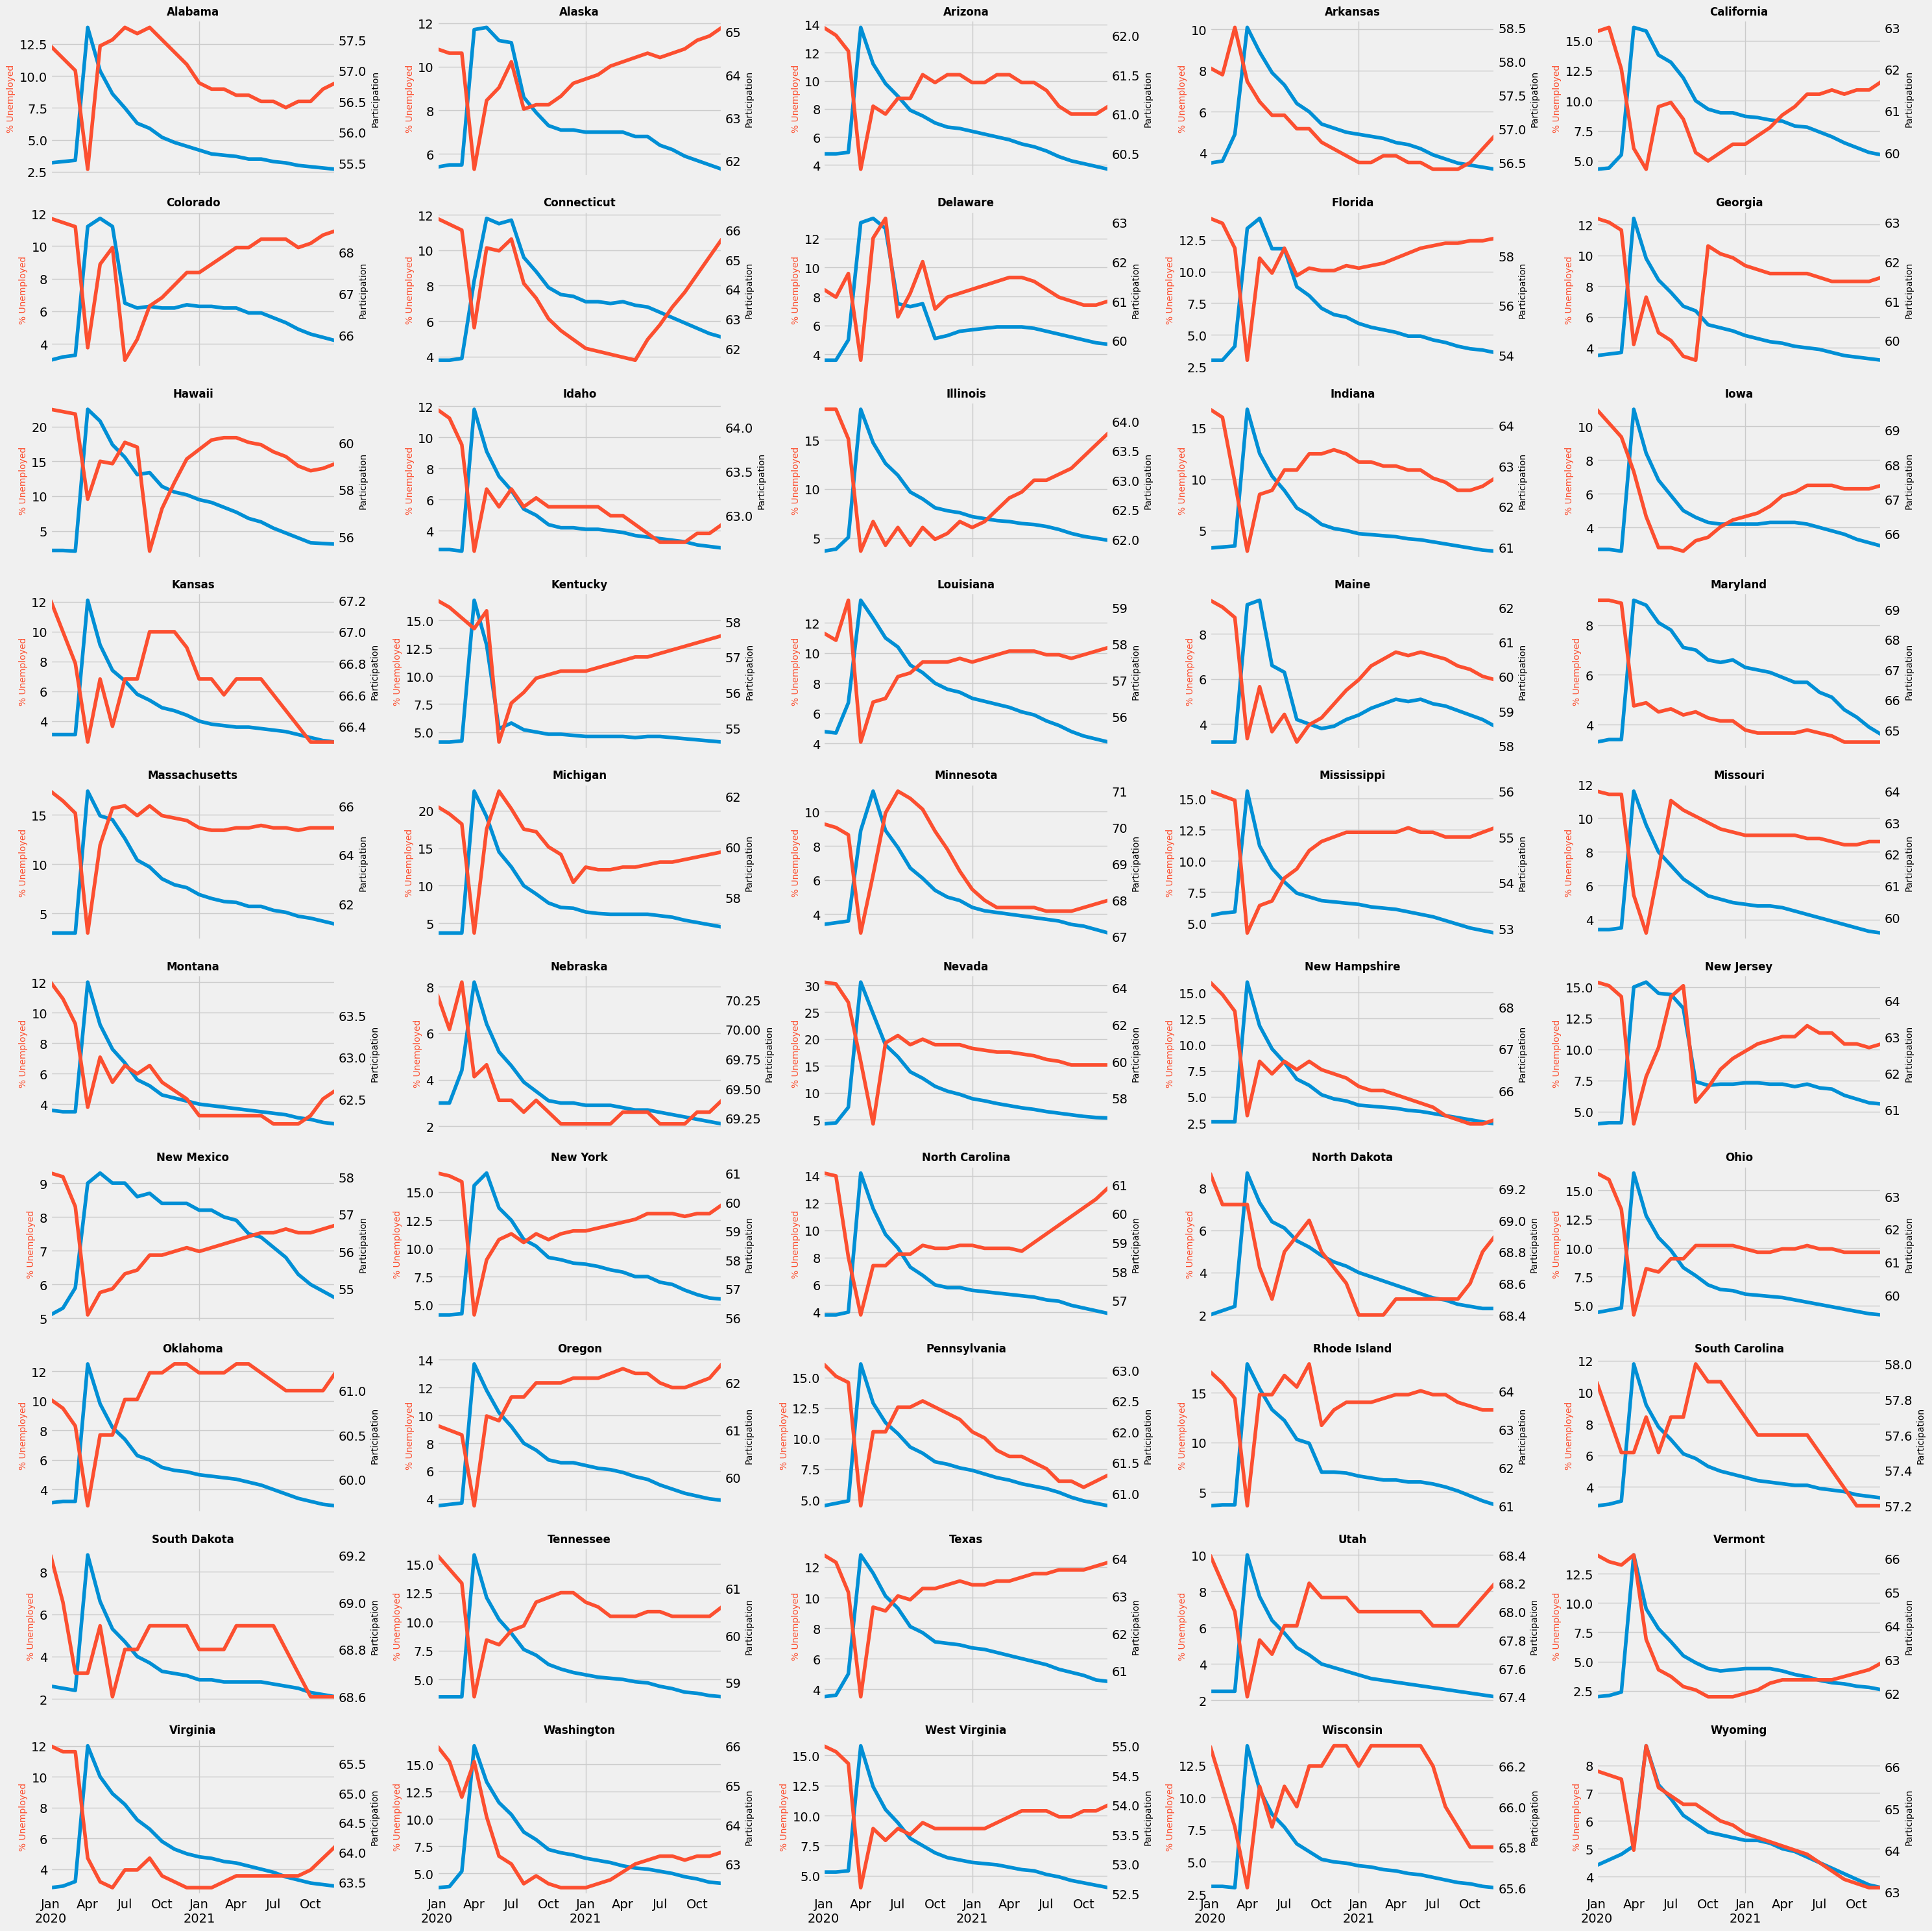

In [20]:
fig, axs = plt.subplots(10,5, figsize=(30, 30), sharex=True)
axs = axs.flatten()

i = 0
for state in sorted(unemp_results.columns):
    if state == 'DC':
        continue
    ax2 = axs[i].twinx()
    unemp_results.query('index >= 2020 and index < 2022')[state] \
        .plot(ax=axs[i])
    part_results.query('index >= 2020 and index < 2022')[state] \
        .plot(ax=ax2, color=color_pal[1])
    ax2.grid(False)
    axs[i].set_title(state, fontsize=12, fontweight='bold')
    axs[i].set_ylabel('% Unemployed', fontsize=10, color=color_pal[1])
    ax2.set_ylabel('Participation', fontsize=10)
    i += 1
plt.tight_layout()
plt.show()